In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql

# Connect to the SQLite database
conn = sql.connect('/kaggle/input/movie-data-analytics-dataset/movie.sqlite')

# Create a cursor
cursor = conn.cursor()

# Execute a SQL query to retrieve table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all table names
table_names = cursor.fetchall()

# Print the table names
print("Tables in the database:")
for table in table_names:
    print(table[0])

Tables in the database:
IMDB
earning
genre


### Lets count how many rows are there for each table:

In [2]:
for table in table_names:
    table_name = table[0]
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    row_count = cursor.fetchone()[0]
    print(f"Table: {table_name}, Row Count: {row_count}")

Table: IMDB, Row Count: 117
Table: earning, Row Count: 117
Table: genre, Row Count: 351


### Now let's see what are the columns for each table:

In [3]:
table_names = ['IMDB', 'earning', 'genre']

for name in table_names:
    columns = []
    
    # Execute a PRAGMA statement to retrieve column names for a table
    cursor.execute(f"PRAGMA table_info({name})")

    # Fetch all rows, each containing information about a column
    column_info = cursor.fetchall()

    # Extract column names from the result
    column_names = [info[1] for info in column_info]

    # Print the column names
    for col in column_names:
        columns.append(col)
    print(f"Column names for {name}:\n {columns}\n")

Column names for IMDB:
 ['Movie_id', 'Title', 'Rating', 'TotalVotes', 'MetaCritic', 'Budget', 'Runtime', 'CVotes10', 'CVotes09', 'CVotes08', 'CVotes07', 'CVotes06', 'CVotes05', 'CVotes04', 'CVotes03', 'CVotes02', 'CVotes01', 'CVotesMale', 'CVotesFemale', 'CVotesU18', 'CVotesU18M', 'CVotesU18F', 'CVotes1829', 'CVotes1829M', 'CVotes1829F', 'CVotes3044', 'CVotes3044M', 'CVotes3044F', 'CVotes45A', 'CVotes45AM', 'CVotes45AF', 'CVotes1000', 'CVotesUS', 'CVotesnUS', 'VotesM', 'VotesF', 'VotesU18', 'VotesU18M', 'VotesU18F', 'Votes1829', 'Votes1829M', 'Votes1829F', 'Votes3044', 'Votes3044M', 'Votes3044F', 'Votes45A', 'Votes45AM', 'Votes45AF', 'VotesIMDB', 'Votes1000', 'VotesUS', 'VotesnUS']

Column names for earning:
 ['Movie_id', 'Domestic', 'Worldwide']

Column names for genre:
 ['Movie_id', 'genre']



### The common column for each table is "Movie_id", which we will use to join the tables and generate a pandas DataFrame

In [4]:
query = 'SELECT * from IMDB'

imdb = pd.read_sql_query(query, conn)

In [5]:
query = '''
SELECT *
FROM IMDB
JOIN earning ON IMDB.Movie_id = earning.Movie_id
JOIN genre ON IMDB.Movie_id = genre.Movie_id
'''

df = pd.read_sql_query(query, conn)

df.head(1)

,Movie_id,Title,Rating,TotalVotes,MetaCritic,Budget,Runtime,CVotes10,CVotes09,CVotes08,...,Votes45AF,VotesIMDB,Votes1000,VotesUS,VotesnUS,Movie_id,Domestic,Worldwide,Movie_id,genre
0,36809,12 Years a Slave (2013),8.1,496092,96,20000000.0,134 min,75556,126223,161460,...,8.1,8.0,7.7,8.3,8.0,36809,56671993,187733202.0,36809,Biography


In [6]:
print(df.columns, df.shape)

Index(['Movie_id', 'Title', 'Rating', 'TotalVotes', 'MetaCritic', 'Budget',
       'Runtime', 'CVotes10', 'CVotes09', 'CVotes08', 'CVotes07', 'CVotes06',
       'CVotes05', 'CVotes04', 'CVotes03', 'CVotes02', 'CVotes01',
       'CVotesMale', 'CVotesFemale', 'CVotesU18', 'CVotesU18M', 'CVotesU18F',
       'CVotes1829', 'CVotes1829M', 'CVotes1829F', 'CVotes3044', 'CVotes3044M',
       'CVotes3044F', 'CVotes45A', 'CVotes45AM', 'CVotes45AF', 'CVotes1000',
       'CVotesUS', 'CVotesnUS', 'VotesM', 'VotesF', 'VotesU18', 'VotesU18M',
       'VotesU18F', 'Votes1829', 'Votes1829M', 'Votes1829F', 'Votes3044',
       'Votes3044M', 'Votes3044F', 'Votes45A', 'Votes45AM', 'Votes45AF',
       'VotesIMDB', 'Votes1000', 'VotesUS', 'VotesnUS', 'Movie_id', 'Domestic',
       'Worldwide', 'Movie_id', 'genre'],
      dtype='object') (351, 57)


In [7]:
df.duplicated('Title').sum()

234

In [8]:
imdb.duplicated('Title').sum()

0

#### There are 234 rows duplicated in the DataFrame. 
#### That is because the 'genre' table has many genres for a unique Movie_id (a many to one type of relationship)
#### 
#### To correct this, let's make a new query concatenating the genres of the 'genre' table in a single column for the new DataFrame:

In [9]:
query = '''
SELECT IMDB.*, earning.*, GROUP_CONCAT(genre.Genre, ', ') AS Genres
FROM IMDB
JOIN earning ON IMDB.Movie_id = earning.Movie_id
JOIN genre ON IMDB.Movie_id = genre.Movie_id
GROUP BY IMDB.Movie_id;
'''

df = pd.read_sql_query(query, conn)

df.head(2)

,Movie_id,Title,Rating,TotalVotes,MetaCritic,Budget,Runtime,CVotes10,CVotes09,CVotes08,...,Votes45AM,Votes45AF,VotesIMDB,Votes1000,VotesUS,VotesnUS,Movie_id,Domestic,Worldwide,Genres
0,10015,Disconnect (2012),7.6,65448,64,10000000.0,115 min,6085,9374,22255,...,7.4,7.6,5.9,6.4,7.4,7.5,10015,1436900,1436900.0,", Drama, Thriller"
1,10023,Wreck-It Ralph (2012),7.7,295125,72,165000000.0,,41980,50262,96477,...,7.4,7.5,7.4,7.2,7.9,7.6,10023,189422889,471222889.0,"Adventure, Animation, Comedy"


## Ok, now we can begin our Exploratory Data Analysis (EDA)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 56 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Movie_id      117 non-null    object 
 1   Title         117 non-null    object 
 2   Rating        117 non-null    float64
 3   TotalVotes    117 non-null    int64  
 4   MetaCritic    117 non-null    object 
 5   Budget        117 non-null    object 
 6   Runtime       117 non-null    object 
 7   CVotes10      117 non-null    object 
 8   CVotes09      117 non-null    object 
 9   CVotes08      117 non-null    object 
 10  CVotes07      117 non-null    object 
 11  CVotes06      117 non-null    object 
 12  CVotes05      117 non-null    object 
 13  CVotes04      117 non-null    object 
 14  CVotes03      117 non-null    object 
 15  CVotes02      117 non-null    object 
 16  CVotes01      117 non-null    object 
 17  CVotesMale    117 non-null    object 
 18  CVotesFemale  117 non-null    

In [11]:
df.Runtime

0      115 min
1             
2             
3      143 min
4      142 min
        ...   
112    133 min
113    134 min
114    123 min
115           
116    147 min
Name: Runtime, Length: 117, dtype: object

### I want to convert every numeric column from object to float64, except from those who already are numeric dtypes and the Runtime column which have empty values

In [12]:
columns_to_convert = ['MetaCritic', 'Budget',
                      'CVotes10', 'CVotes09', 'CVotes08', 'CVotes07', 'CVotes06',
                      'CVotes05', 'CVotes04', 'CVotes03', 'CVotes02', 'CVotes01',
                      'CVotesMale', 'CVotesFemale', 'CVotesU18', 'CVotesU18M', 'CVotesU18F',
                      'CVotes1829', 'CVotes1829M', 'CVotes1829F', 'CVotes3044', 'CVotes3044M',
                      'CVotes3044F', 'CVotes45A', 'CVotes45AM', 'CVotes45AF', 'CVotes1000',
                      'CVotesUS', 'CVotesnUS', 'VotesM', 'VotesF', 'VotesU18', 'VotesU18M',
                      'VotesU18F', 'Votes1829', 'Votes1829M', 'Votes1829F', 'Votes3044',
                      'Votes3044M', 'Votes3044F', 'Votes45A', 'Votes45AM', 'Votes45AF',
                      'VotesIMDB', 'Votes1000', 'VotesUS', 'VotesnUS']

# Replace empty or non-numeric values with NaN
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

df[columns_to_convert] = df[columns_to_convert].astype('float64')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 56 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Movie_id      117 non-null    object 
 1   Title         117 non-null    object 
 2   Rating        117 non-null    float64
 3   TotalVotes    117 non-null    int64  
 4   MetaCritic    110 non-null    float64
 5   Budget        114 non-null    float64
 6   Runtime       117 non-null    object 
 7   CVotes10      117 non-null    float64
 8   CVotes09      117 non-null    float64
 9   CVotes08      117 non-null    float64
 10  CVotes07      117 non-null    float64
 11  CVotes06      117 non-null    float64
 12  CVotes05      117 non-null    float64
 13  CVotes04      117 non-null    float64
 14  CVotes03      117 non-null    float64
 15  CVotes02      117 non-null    float64
 16  CVotes01      117 non-null    float64
 17  CVotesMale    117 non-null    float64
 18  CVotesFemale  117 non-null    

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


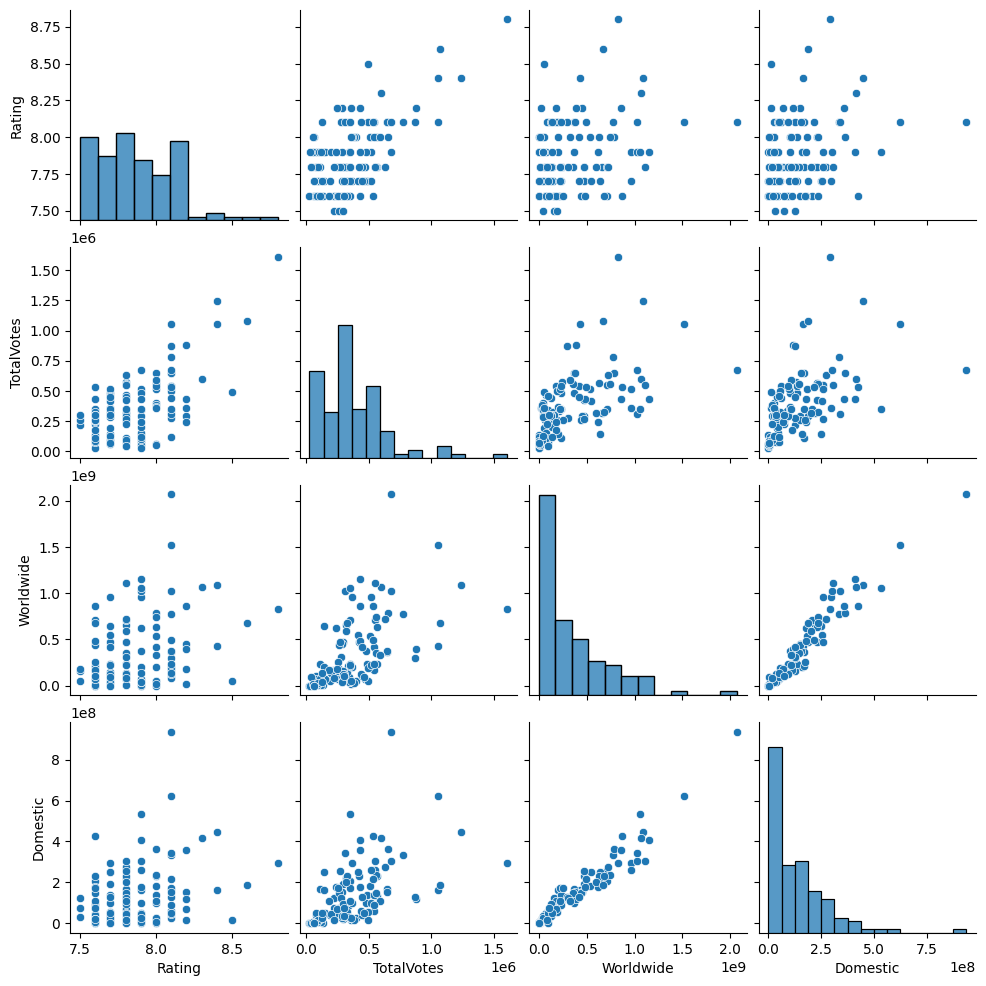

In [14]:
# Subset the DataFrame with the selected columns
selected_df = df.drop(columns=['Title', 'Movie_id','Runtime','Genres'])

# Pairplot for a subset of columns to visualize relationships
sns.pairplot(selected_df[['Rating', 'TotalVotes', 'Worldwide', 'Domestic']])
plt.show()

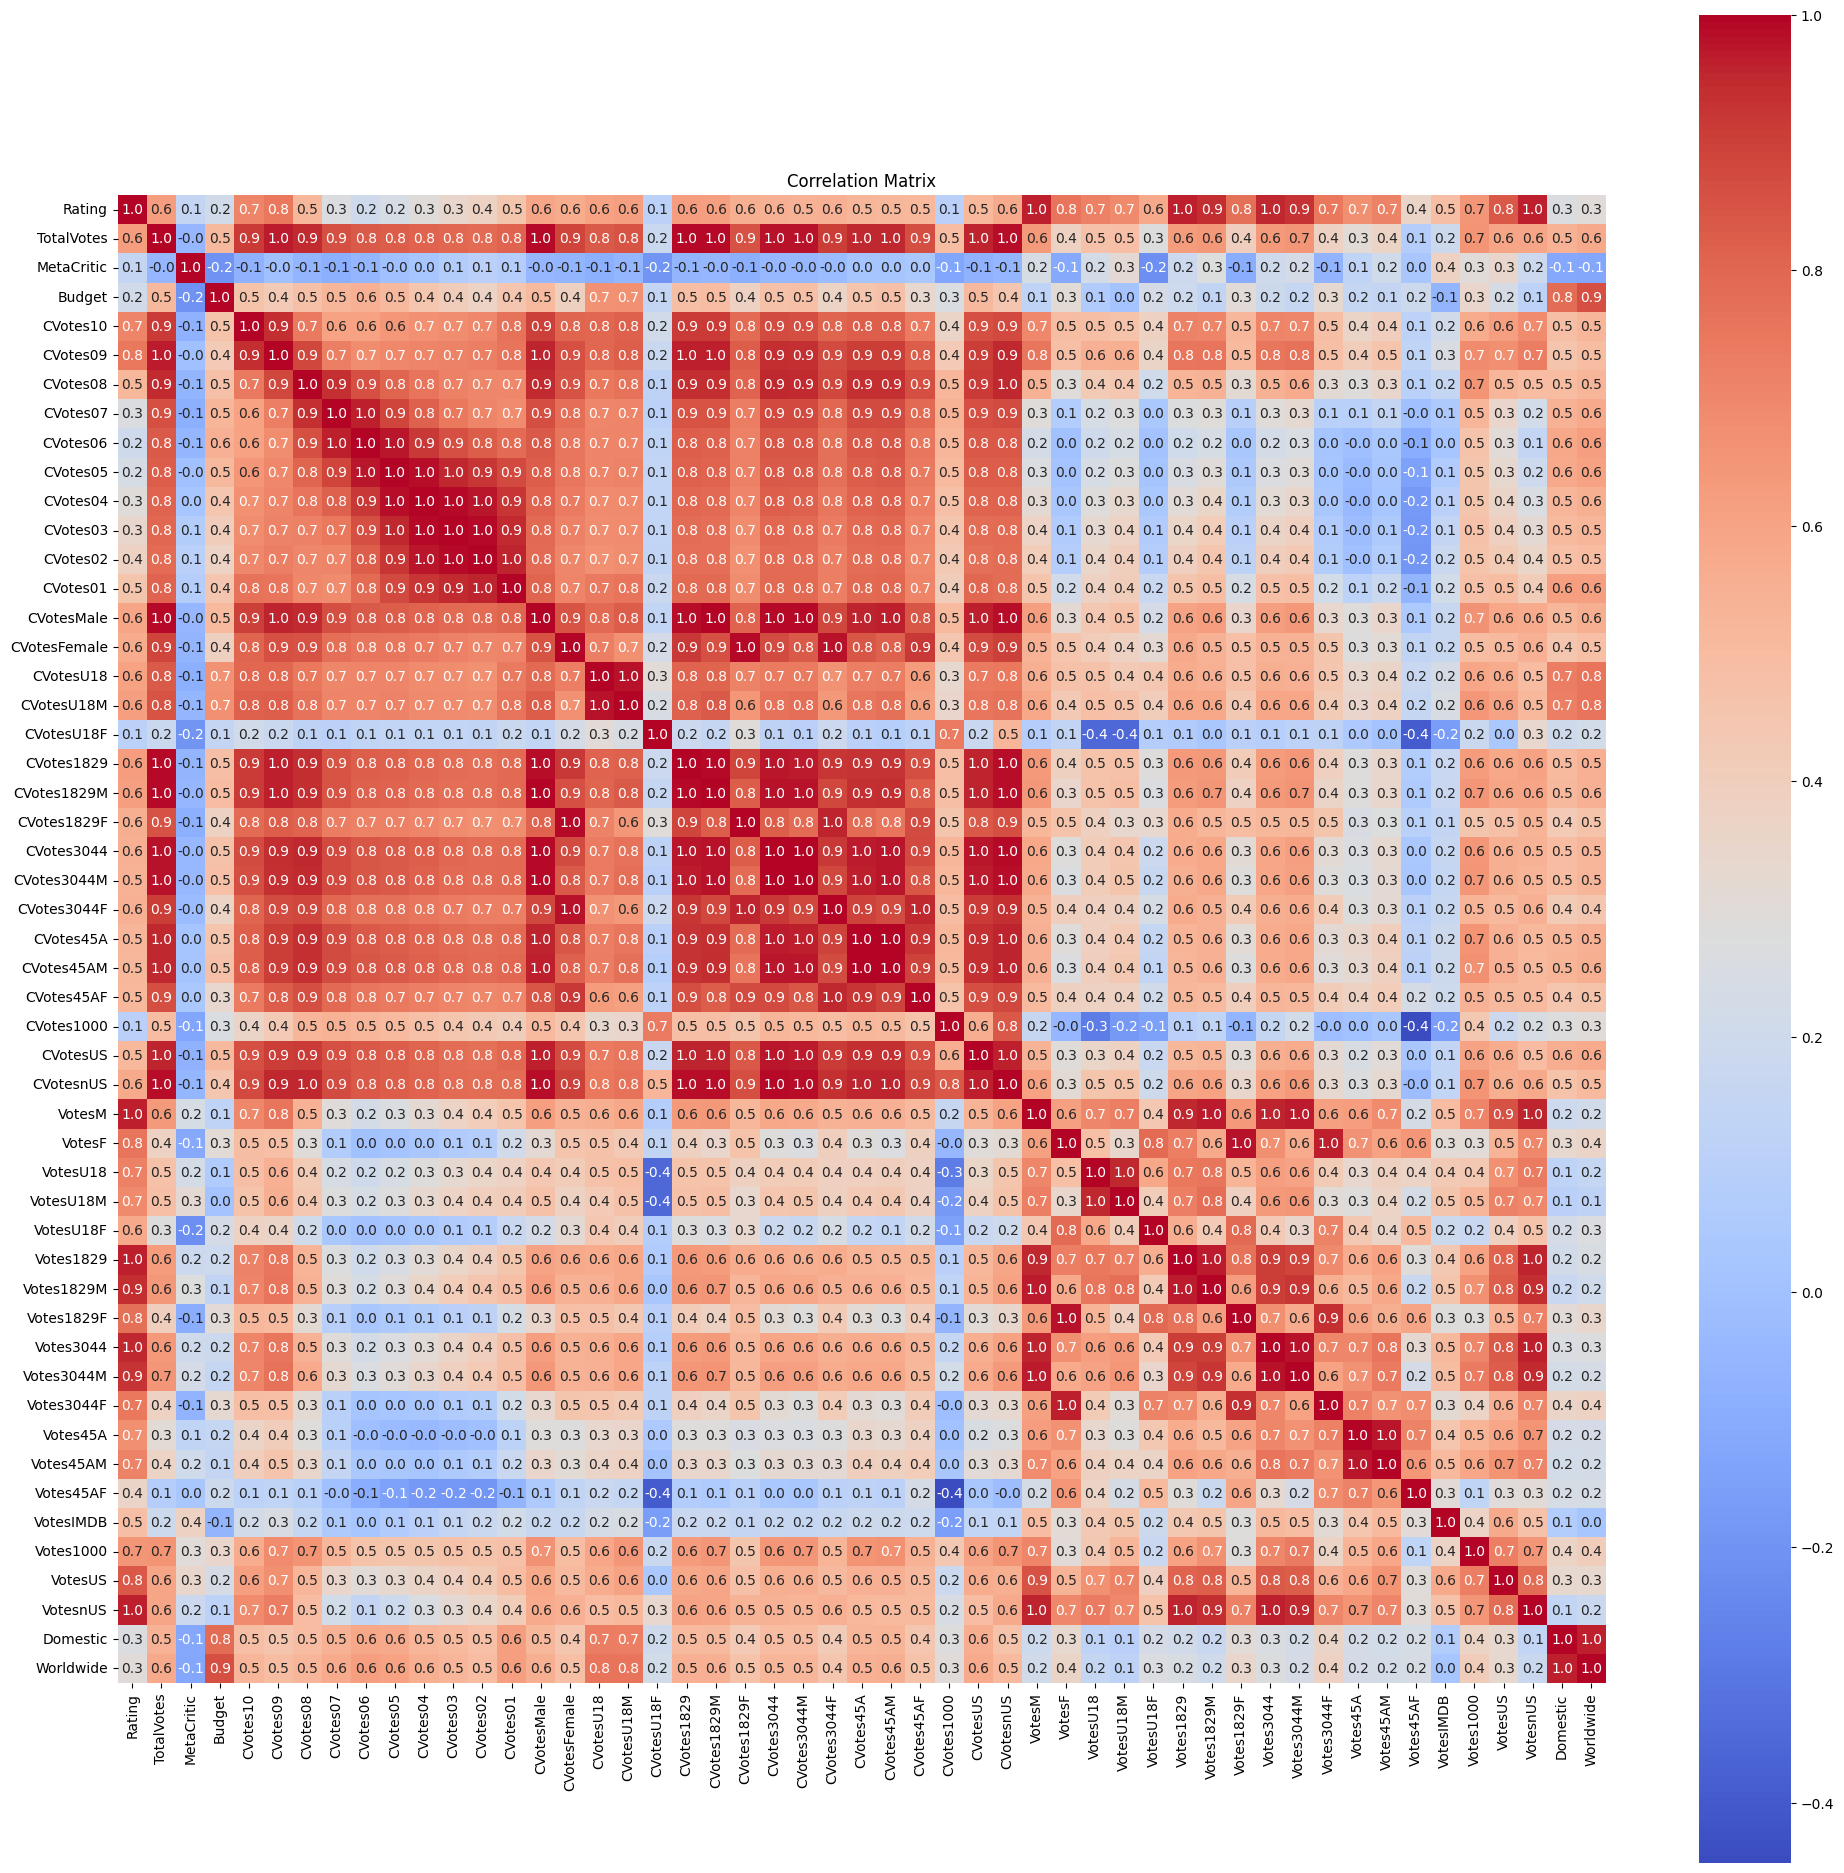

In [15]:
correlation_matrix = selected_df.corr()
plt.figure(figsize=(24, 24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.1f')
plt.title('Correlation Matrix')
plt.show()

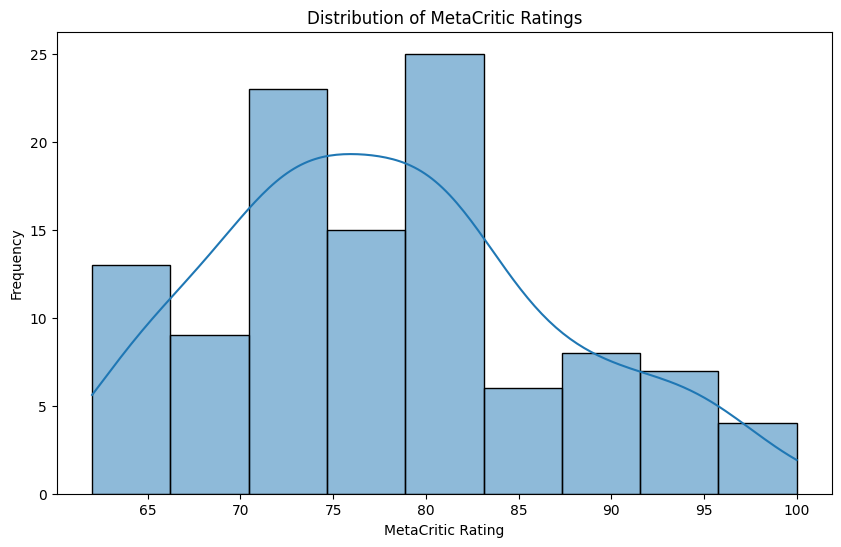

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(selected_df['MetaCritic'].dropna(), kde=True)
plt.xlabel('MetaCritic Rating')
plt.ylabel('Frequency')
plt.title('Distribution of MetaCritic Ratings')
plt.show()

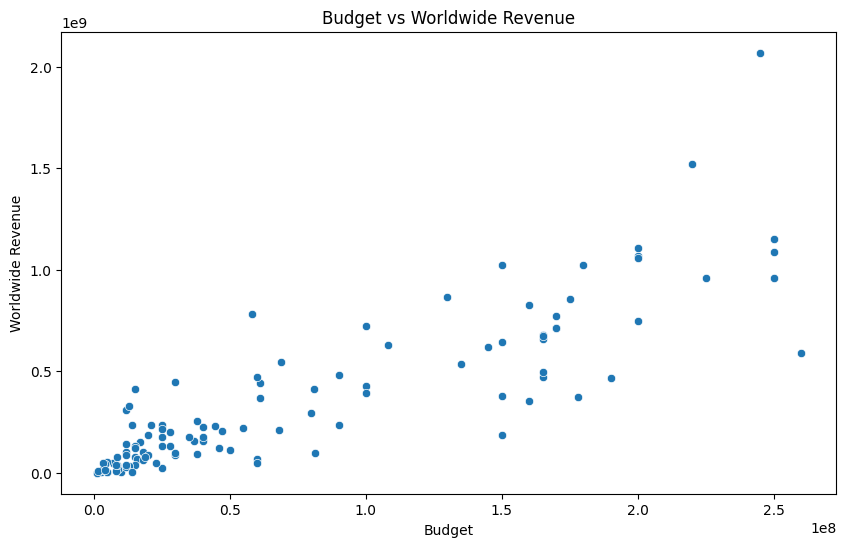

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=selected_df, x='Budget', y='Worldwide')
plt.xlabel('Budget')
plt.ylabel('Worldwide Revenue')
plt.title('Budget vs Worldwide Revenue')
plt.show()

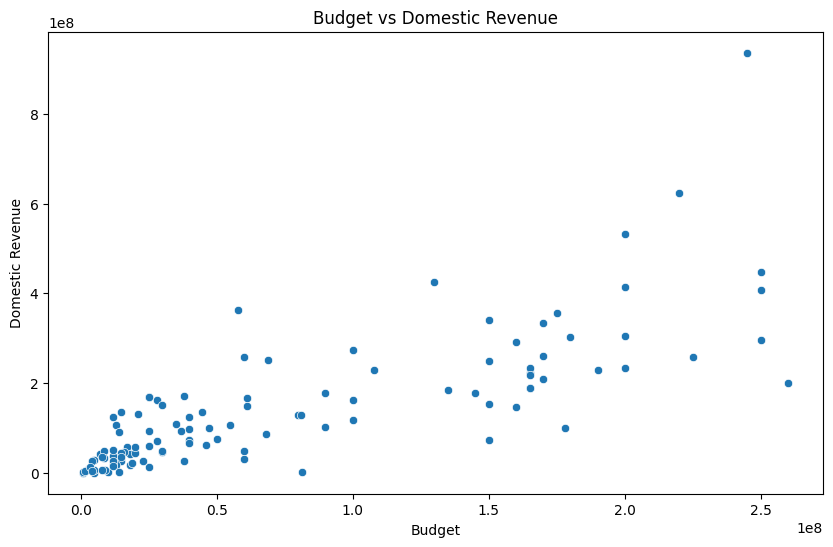

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=selected_df, x='Budget', y='Domestic')
plt.xlabel('Budget')
plt.ylabel('Domestic Revenue')
plt.title('Budget vs Domestic Revenue')
plt.show()

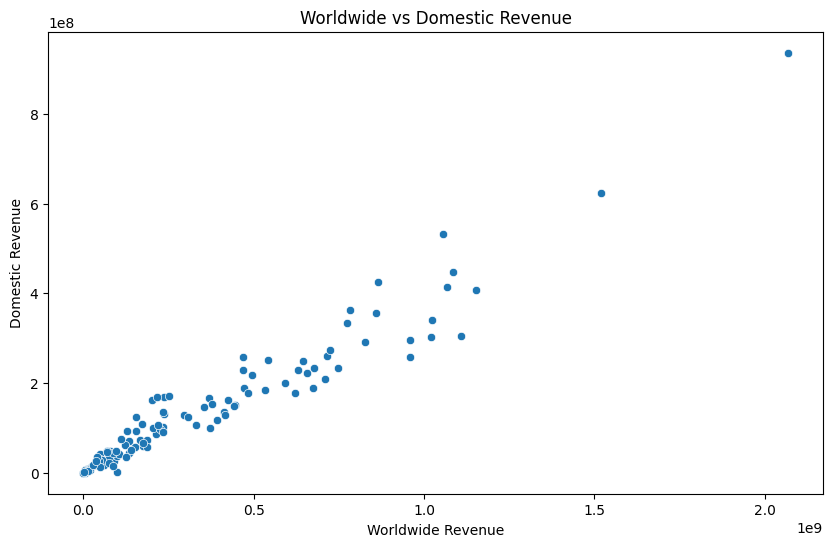

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=selected_df, x='Worldwide', y='Domestic')
plt.xlabel('Worldwide Revenue')
plt.ylabel('Domestic Revenue')
plt.title('Worldwide vs Domestic Revenue')
plt.show()